## Importing modules 

In [ ]:
# imports
import pandas as pd
import seaborn as sns

## Reading CSV file & previewing the data

In [3]:
file = 'who_suicide_statistics.csv'
whoss_df = pd.read_csv(file)

# having 'years' in the age group seems unnecessary, and '05-14' will sort better than '5-14'
whoss_df.loc[:, 'age'] = whoss_df['age'].str.replace(' years','')
whoss_df.loc[whoss_df['age'] == '5-14', 'age'] = '05-14'

# crude rate calculation
whoss_df['crude_rate_per_100k'] = whoss_df['suicides_no'] / (whoss_df['population'] / 100000)

# preview
pd.concat([whoss_df[:2], whoss_df[10000:10002], whoss_df[-2:]])

,country,year,sex,age,suicides_no,population,crude_rate_per_100k
0,Albania,1985,female,15-24,NaN,277900.0,NaN
1,Albania,1985,female,25-34,NaN,246800.0,NaN
10000,Croatia,2007,female,55-74,84.0,533554.0,15.743486
10001,Croatia,2007,female,75+,45.0,204595.0,21.994672
43774,Zimbabwe,1990,male,55-74,74.0,NaN,NaN
43775,Zimbabwe,1990,male,75+,13.0,NaN,NaN


## Getting th infor of who_suicide_statistics file

In [4]:
whoss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43776 entries, 0 to 43775
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              43776 non-null  object 
 1   year                 43776 non-null  int64  
 2   sex                  43776 non-null  object 
 3   age                  43776 non-null  object 
 4   suicides_no          41520 non-null  float64
 5   population           38316 non-null  float64
 6   crude_rate_per_100k  36060 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 2.3+ MB


## Suicide count by country name and age

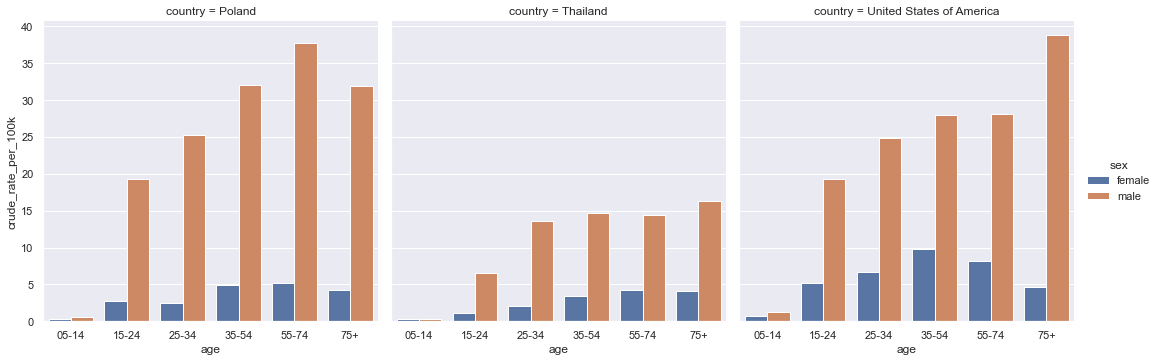

In [5]:
# seaborn settings reset
sns.set()

# chart data
cd = (whoss_df.loc[(whoss_df['country'].isin(['Poland','Thailand','United States of America'])) 
             & (whoss_df['year'] == 2015), ['country','sex','age','crude_rate_per_100k']]
      .sort_values(['sex','age']))

sns.catplot(x='age', hue='sex', col='country', y='crude_rate_per_100k'
            , data=cd, kind='bar', col_wrap=3)

## Suicide rate by decades( 1996-2005 & 2006-2015) 

In [6]:
# grouping into two decades of interest
whoss_df.loc[(whoss_df['year'] >= 1996) & (whoss_df['year'] <= 2005), 'decade'] = '1996-2005'
whoss_df.loc[(whoss_df['year'] >= 2006) & (whoss_df['year'] <= 2015), 'decade'] = '2006-2015'

# median of the crude rate in a decade, along with information about how many years of data are available
stats_by_decade_df = (whoss_df.groupby(['country','decade','sex','age'])['crude_rate_per_100k']
                      .agg(['median','count'])
                      .reset_index()
                     )

stats_by_decade_df.head()

,country,decade,sex,age,median,count
0,Albania,1996-2005,female,05-14,0.278641,10
1,Albania,1996-2005,female,15-24,5.317182,10
2,Albania,1996-2005,female,25-34,3.682569,10
3,Albania,1996-2005,female,35-54,2.452446,10
4,Albania,1996-2005,female,55-74,1.779099,10


## select only these cases where we have at least X years of data

In [7]:
# select only these cases where we have at least X years of data
valid_threshold = 5

# fraction_above_threshold = sum(stats_by_decade_df['count'] >= valid_threshold) / len(stats_by_decade_df)
# print('There are {0:.1%} rows with at least {1} years of data.'
#       .format(fraction_above_threshold, valid_threshold))

##  difference in median of crude rates between two decades

In [8]:
# difference in median of crude rates between two decades
# perhaps there is a better way to calculate this, instead of doing two calculations and joining them into one table
d1_df = stats_by_decade_df[(stats_by_decade_df['decade'] == '1996-2005') & (stats_by_decade_df['count'] >= valid_threshold)]
d2_df = stats_by_decade_df[(stats_by_decade_df['decade'] == '2006-2015') & (stats_by_decade_df['count'] >= valid_threshold)]

final_df = d1_df.merge(d2_df, left_on=['country','sex','age'], 
            right_on=['country','sex','age'], how='inner',
           suffixes=['_d1','_d2'])
           
final_df['crude_rate_diff'] = final_df['median_d2'] - final_df['median_d1']

# capping on crude rates difference
final_df.loc[final_df['crude_rate_diff'] > 20, 'crude_rate_diff'] = 20
final_df.loc[final_df['crude_rate_diff'] < -20, 'crude_rate_diff'] = -20

print('There are', final_df['country'].nunique(), 'countries with at least', valid_threshold, 'years of data.')
final_df.head()

There are 93 countries with at least 5 years of data.


,country,decade_d1,sex,age,median_d1,count_d1,decade_d2,median_d2,count_d2,crude_rate_diff
0,Albania,1996-2005,female,05-14,0.278641,10,2006-2015,0.000000,5,-0.278641
1,Albania,1996-2005,female,15-24,5.317182,10,2006-2015,2.276340,5,-3.040842
2,Albania,1996-2005,female,25-34,3.682569,10,2006-2015,3.268348,5,-0.414221
3,Albania,1996-2005,female,35-54,2.452446,10,2006-2015,3.041108,5,0.588662
4,Albania,1996-2005,female,55-74,1.779099,10,2006-2015,2.898659,5,1.119560


## Result

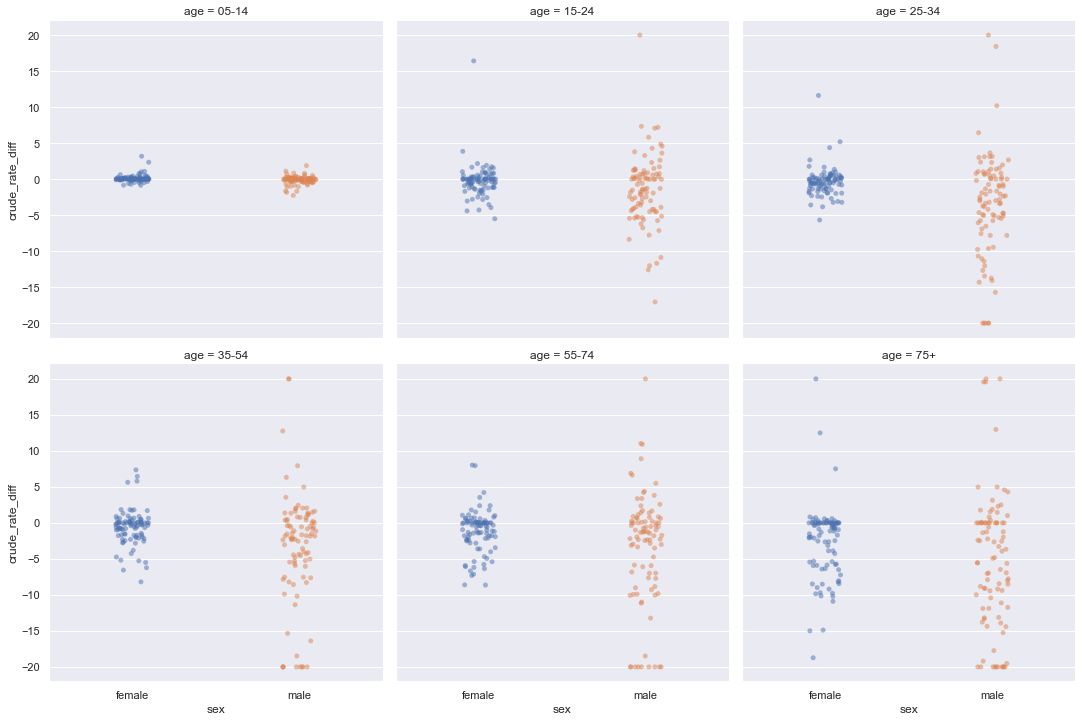

In [9]:
sns.catplot(x='sex', y="crude_rate_diff", col="age", col_wrap=3, sharey=True, data=final_df, alpha=0.5)

## decide what qualifies as change (increase or decrease)

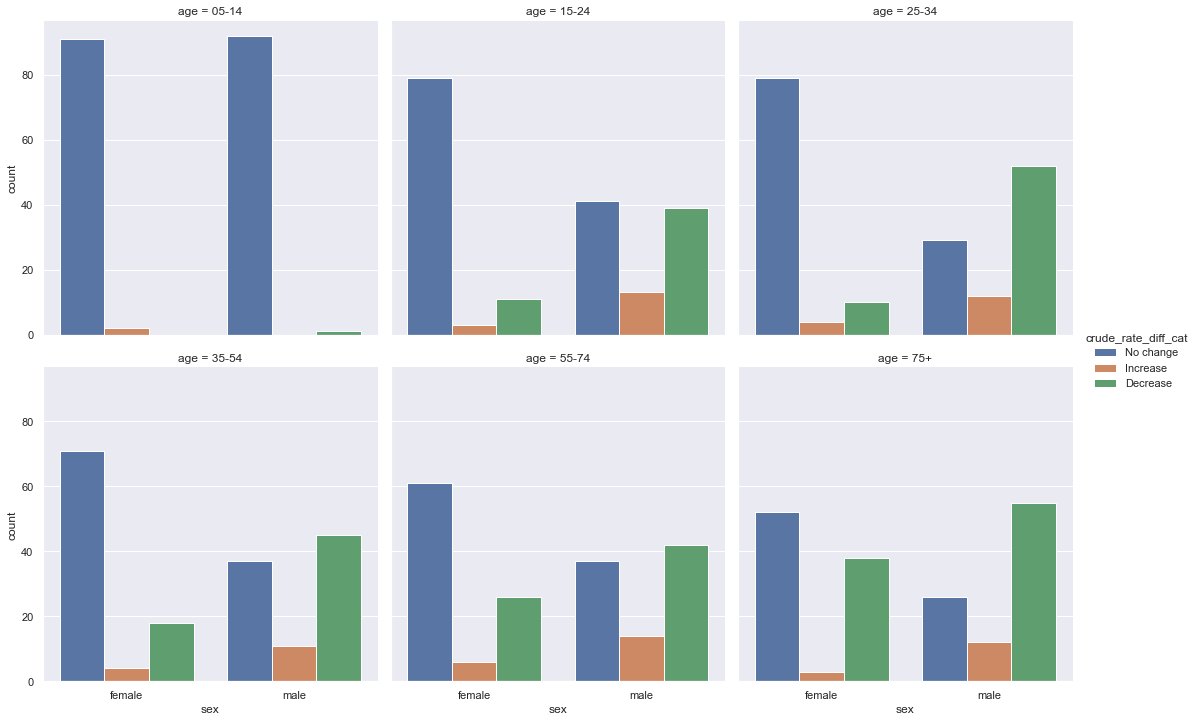

In [10]:
# decide what qualifies as change (increase or decrease)
def categorize_differences(x, threshold):
    if (x <= -threshold):
        diff_category = 'Decrease'
    elif (x >= threshold):
        diff_category = 'Increase'
    else:
        diff_category = 'No change'
    
    return diff_category
        
final_df['crude_rate_diff_cat'] = final_df['crude_rate_diff'].map(lambda x: categorize_differences(x, 2))

# results
sns.catplot(x='sex', hue='crude_rate_diff_cat', col='age', col_wrap=3, 
            data=final_df.sort_values(['age','crude_rate_diff_cat','sex'], ascending=[True,False,True]), 
            kind='count')

## Further analysis: 1986-1995 extension

There are 75 countries with at least 5 years of data.


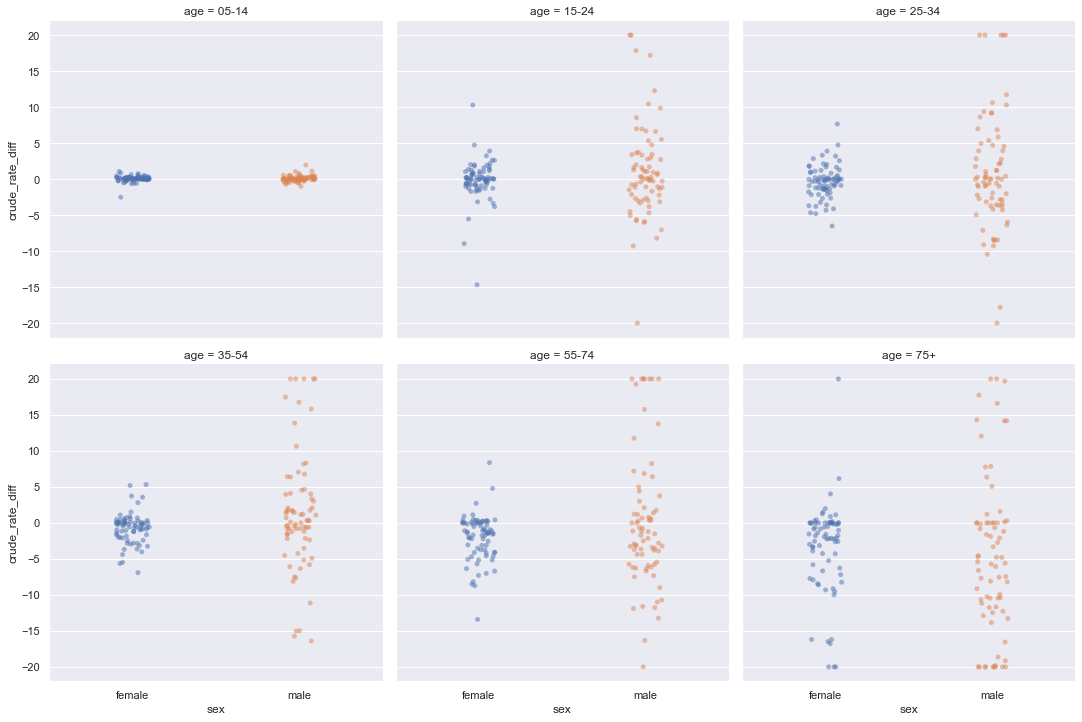

In [11]:
# let's rerun all the stuff just once more
whoss_df.loc[(whoss_df['year'] >= 1996) & (whoss_df['year'] <= 2005), 'decade'] = '1996-2005'
whoss_df.loc[(whoss_df['year'] >= 1986) & (whoss_df['year'] <= 1995), 'decade'] = '1986-1995'

stats_by_decade_df = (whoss_df.groupby(['country','decade','sex','age'])['crude_rate_per_100k']
                      .agg(['median','count'])
                      .reset_index()
                     )

d1_df = stats_by_decade_df[(stats_by_decade_df['decade'] == '1986-1995') & (stats_by_decade_df['count'] >= valid_threshold)]
d2_df = stats_by_decade_df[(stats_by_decade_df['decade'] == '1996-2005') & (stats_by_decade_df['count'] >= valid_threshold)]

final_df = d1_df.merge(d2_df, left_on=['country','sex','age'], 
            right_on=['country','sex','age'], how='inner',
           suffixes=['_d1','_d2'])
           
final_df['crude_rate_diff'] = final_df['median_d2'] - final_df['median_d1']

final_df.loc[final_df['crude_rate_diff'] > 20, 'crude_rate_diff'] = 20
final_df.loc[final_df['crude_rate_diff'] < -20, 'crude_rate_diff'] = -20

print('There are', final_df['country'].nunique(), 'countries with at least', valid_threshold, 'years of data.')
sns.catplot(x='sex', y="crude_rate_diff", col="age", col_wrap=3, sharey=True, data=final_df, alpha=0.5)

## final results

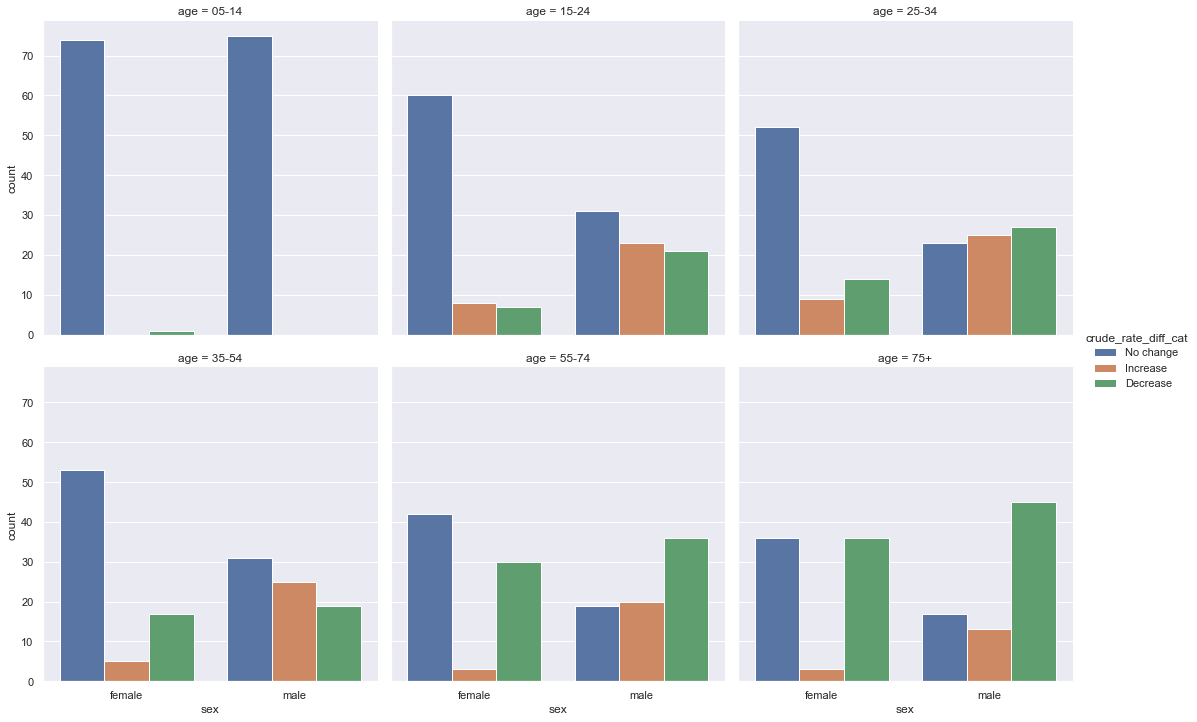

In [12]:
final_df['crude_rate_diff_cat'] = final_df['crude_rate_diff'].map(lambda x: categorize_differences(x, 2))

sns.catplot(x='sex', hue='crude_rate_diff_cat', col='age', col_wrap=3, 
            data=final_df, kind='count')

## It seems that the generally optimistic trend that we saw in the main part of this notebook is not a new phenomenon. The 1996-2005 decade was already better than 1986-1995, though only the older age groups (55+) seemed to benefit clearly. Let's keep in mind these were - and often still are - the people with the highest risk of suicide, so it looks that some relief came first to the ones who needed it the most.